

The `tyssue` library seeks to provide a unified interface to implement
bio-mechanical models of living tissues. It's main focus is on **vertex based epithelium models**.


### Outline

1. Core objects and datastructures

2. Visualisation

3. Quasistatic models

4. Event management


[tyssue docs](https://tyssue.readthedocs.io/en/latest/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv


# Core objects and geometry

from tyssue import (
    Monolayer,
    ClosedMonolayerGeometry,
    Sheet,
    ClosedSheetGeometry
)

# Generation tools
from tyssue import generation

# Viz
from tyssue.draw import sheet_view

# Dynamical model
from tyssue.dynamics import model_factory, effectors

## Data structure


![Tyssue data structure](data/svg/data_model.svg)


Two main class of models: 2D in 2D or 3D (`Sheet`) and full 3D, multilayer (`Epithelium`) or monolayer (`Monolayer`).

There are three (resp. 4) datasets, representing vertices, edges, faces (and cells).

The main idea is to do the computation on the `edge` dataset, as it retains a reference to the indices of its source (`srce`) and target (`trgt`) vertices, its `face` (and its `cell`). There are mechanisms to copy the data belonging to a vertex or a face to the corresponding edges, called upcasting. 

The edges are actually half-edges in 2D and in 3D the data structure is that of a Linear Cell Complex (CGAL).


In [57]:
%timeit ClosedMonolayerGeometry.update_all(mono)


109 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
mono = generation.spherical_monolayer(10, 12, 100)
ClosedMonolayerGeometry.update_all(mono)
print(mono.Nc)

182


In [59]:
apical_sheet = mono.get_sub_sheet("apical")
apical_sheet.reset_index()
apical_sheet.reset_topo()

ClosedSheetGeometry.update_all(apical_sheet)

In [60]:
ipv.clear()
fig, mesh = sheet_view(mono, mode="3D", face={"visible": False})
fig

/home/guillaume/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

Each dataset can be accessed as a value of the `mono.datasets` dictionnary or through `mono.edge_df` (or `mono.face_df`, etc).

In [39]:
mono.datasets.keys()

dict_keys(['cell', 'vert', 'edge', 'face'])

In [50]:
from tyssue.io import obj

obj.save_junction_mesh("test.obj", mono)

In [40]:
mono.datasets['cell'].head()

,x,y,z,is_alive,area,vol,num_faces,num_ridges
cell,,,,,,,,
0,-1.771128,-5.117349,-8.773759,1,63.032706,-32.217097,8,36
1,-0.498756,-7.532178,-5.408639,1,53.894137,-26.609051,10,48
2,-4.090607,-6.606667,-6.002684,1,46.031622,-20.828427,7,30
3,3.096127,6.712052,10.540596,1,57.239452,-27.767288,7,30
4,4.736138,10.555625,7.683949,1,90.907471,-51.235093,9,42


In [41]:
mono.edge_df.head()

,srce,trgt,face,dx,dy,dz,nx,ny,nz,sx,...,uy,uz,edge_o,srce_o,trgt_o,face_o,cell_o,sub_area,is_valid,segment
edge,,,,,,,,,,,,,,,,,,,,,
0,28,0,0,-1.864921,-0.287282,0.634712,-0.497366,-2.982764,-2.811420,-0.166006,...,0,0,0,28,0,0,0,2.064482,True,basal
1,170,169,129,-0.795092,-0.124975,0.446275,0.257935,-0.625810,0.284291,4.162625,...,0,0,1560,170,169,129,0,0.367080,True,basal
2,78,79,65,1.135073,1.388797,-0.709251,2.860254,-0.706708,3.193686,7.250890,...,0,0,790,78,79,65,0,2.172563,True,basal
3,295,170,129,-0.021509,0.396630,0.897120,0.254224,-0.614782,0.277900,4.184134,...,0,0,1562,295,170,129,0,0.360491,True,basal
4,84,78,65,1.567257,0.393904,-1.146787,2.717778,-0.866624,3.416579,5.683633,...,0,0,788,84,78,65,0,2.225442,True,basal


In [314]:
from tyssue import Sheet, SheetGeometry
from tyssue.generation import generate_ring


sheet = generate_ring(24, 12, 18)

PlanarGeometry.update_all(sheet)

In [324]:

## Angle θ of the source in the cylindrical coordinate system
theta = np.arctan2(sheet.edge_df["sy"], sheet.edge_df["sx"],)
cost, sint = np.cos(theta), np.sin(theta)

# One rotation matrix per edge
rot_mat = np.array(
    [[cost, sint],
     [-sint, cost]]
)
print('Shape of rotation matrices', rot_mat.shape)

# We want to get the edge coordinates w/r to θ
dx_dy = sheet.edge_df[['dx', 'dy']].to_numpy()
sheet.edge_df['dx_r'] = sheet.edge_df['dx'].copy()
sheet.edge_df['dy_r'] = sheet.edge_df['dy'].copy()

# numpy einsum magic (need lots of trial and error :/)
sheet.edge_df[['dx_r', 'dy_r']] = np.einsum('jik, ki-> kj', rot_mat, dx_dy)

# φ is the angle we want
sheet.edge_df["phi"] = np.arctan2(sheet.edge_df['dz'], sheet.edge_df['dx_r'])



Shape of rotation matrices (2, 2, 96)


KeyError: 'dz'

In [317]:
rot_mat.shape

(2, 2, 96)

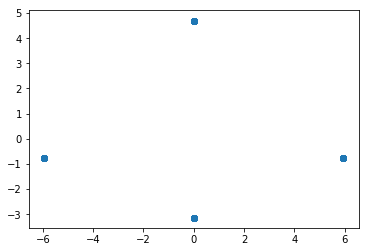

In [322]:
fig, ax = plt.subplots()
ax.scatter(sheet.edge_df['dx_r'], sheet.edge_df['dy_r'], alpha=0.8)

ax.set_aspect("equal")

In [319]:
phi = np.arctan2(sheet.edge_df['dy_r'], sheet.edge_df['dx_r'])

In [320]:
sheet.face_df['theta'] = np.arctan2(sheet.face_df['y'], sheet.face_df['x'])

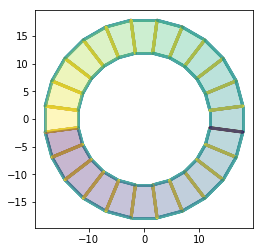

In [323]:
fig, mesh = sheet_view(
    sheet, mode="2D", 
    edge={"color": np.abs(phi), "width": 3},
    face={"visible":True, "color": sheet.face_df["theta"], "alpha": 0.3})
